In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder


In [2]:
data=pd.read_csv('processed_dataset.csv')

data

,city,population,total_cases,carried_over_from,opened_inside_year,finished,carried_over_to,time_since_event,population_density
0,İstanbul,15099946.0,2378387,1536743,841644,836525,1541862,3,2765.051456
1,Tekirdağ,1105759.0,127163,59444,67719,62603,64560,3,178.636349
2,Edirne,406215.0,50363,24888,25475,27064,23299,3,66.104963
3,Kırklareli,363245.0,31716,12732,18984,18939,12777,3,56.238582
4,Balıkesir,1238619.0,139589,66047,73542,74267,65322,3,84.935816
...,...,...,...,...,...,...,...,...,...
1048,Diyarbakır,1514793.0,89211,47222,41989,38964,50247,15,100.310774
1049,Mardin,736455.0,24841,7067,17774,15843,8998,15,83.878702
1050,Batman,497841.0,22390,8826,13564,13984,8406,15,111.199687
1051,Şırnak,430006.0,13615,3692,9923,9707,3908,15,60.752472


In [3]:
import random
random.seed(42)

# Preprocessing

In [4]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X.squeeze())
        return self

    def transform(self, X, y=None):
        return self.encoder.transform(X.squeeze()).reshape(-1, 1)


In [5]:
# İlk pipeline: city sütununu etiketlemek
label_encoding_pipeline = Pipeline(steps=[
    ('label_enc', LabelEncoderTransformer())
])

# Tüm sütunları içeren ColumnTransformer: city sütununu encode edip diğer sütunları eklemek
# Doğru sıralama ve indekslerle güncellenmiş ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('label_enc', label_encoding_pipeline, ['city']),
        ('pass', 'passthrough', ['population', 'carried_over_from', 'total_cases',
                                 'opened_inside_year', 'carried_over_to', 'finished',
                                 'time_since_event', 'population_density'])
    ]
)



In [6]:
# preprocessor'ı veri setine uygulama ve sonucu al
transformed_data = preprocessor.fit_transform(data)

# Dönüştürülmüş veriyi DataFrame olarak geri döndürme
transformed_df = pd.DataFrame(transformed_data, columns=['city_label_encoded', 'population',
                                                         'carried_over_from', 'total_cases',
                                                         'opened_inside_year', 'carried_over_to',
                                                         'finished', 'time_since_event',
                                                         'population_density'])

transformed_df


,city_label_encoded,population,carried_over_from,total_cases,opened_inside_year,carried_over_to,finished,time_since_event,population_density
0,77.0,15099946.0,1536743.0,2378387.0,841644.0,1541862.0,836525.0,3.0,2765.051456
1,65.0,1105759.0,59444.0,127163.0,67719.0,64560.0,62603.0,3.0,178.636349
2,24.0,406215.0,24888.0,50363.0,25475.0,23299.0,27064.0,3.0,66.104963
3,46.0,363245.0,12732.0,31716.0,18984.0,12777.0,18939.0,3.0,56.238582
4,11.0,1238619.0,66047.0,139589.0,73542.0,65322.0,74267.0,3.0,84.935816
...,...,...,...,...,...,...,...,...,...
1048,22.0,1514793.0,47222.0,89211.0,41989.0,50247.0,38964.0,15.0,100.310774
1049,51.0,736455.0,7067.0,24841.0,17774.0,8998.0,15843.0,15.0,83.878702
1050,13.0,497841.0,8826.0,22390.0,13564.0,8406.0,13984.0,15.0,111.199687
1051,80.0,430006.0,3692.0,13615.0,9923.0,3908.0,9707.0,15.0,60.752472


In [7]:
from sklearn.compose import make_column_selector as selector

# Sadece belirli sütunları ölçeklendirme yapacak ColumnTransformer
scaler_transformer = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), ['city_label_encoded', 'population', 'time_since_event', 'population_density'])
    ],
    remainder='passthrough'
)

In [8]:
# Pipeline oluşturma
pipeline = Pipeline(steps=[
    ('scaler', scaler_transformer)
])

In [9]:
# Pipeline'ı veri setine uygulama
processed_data = pipeline.fit_transform(transformed_df)

# Dönüştürülmüş veriyi DataFrame olarak geri döndürme
processed_df = pd.DataFrame(processed_data, columns=['city_label_encoded', 'population',
                                                        'time_since_event','population_density',
                                                         'carried_over_from',  'total_cases',
                                                       'opened_inside_year','carried_over_to' ,
                                                           'finished'
                                                       ])

processed_df

,city_label_encoded,population,time_since_event,population_density,carried_over_from,total_cases,opened_inside_year,carried_over_to,finished
0,0.925,19.785894,-1.0,39.361131,1536743.0,2378387.0,841644.0,1541862.0,836525.0
1,0.625,0.792878,-1.0,1.726081,59444.0,127163.0,67719.0,64560.0,62603.0
2,-0.400,-0.156548,-1.0,0.088631,24888.0,50363.0,25475.0,23299.0,27064.0
3,0.150,-0.214868,-1.0,-0.054935,12732.0,31716.0,18984.0,12777.0,18939.0
4,-0.725,0.973197,-1.0,0.362640,66047.0,139589.0,73542.0,65322.0,74267.0
...,...,...,...,...,...,...,...,...,...
1048,-0.450,1.348022,1.0,0.586362,47222.0,89211.0,41989.0,50247.0,38964.0
1049,0.275,0.291656,1.0,0.347258,7067.0,24841.0,17774.0,8998.0,15843.0
1050,-0.675,-0.032193,1.0,0.744807,8826.0,22390.0,13564.0,8406.0,13984.0
1051,1.000,-0.124259,1.0,0.010747,3692.0,13615.0,9923.0,3908.0,9707.0


# Accuracy Calculation Function

In [10]:
def calculate_accuracy(y_pred, y_true):
  # Print predicted and real y-values for the first 10 rows
  # for i in range(10):
  #     print("Predicted:", y_pred[i], "\tReal:", y_true.iloc[i])

  # Calculate absolute percentage error for each prediction
  absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)

  # Calculate mean absolute percentage error
  mape = np.mean(absolute_percentage_errors)

  # Convert MAPE to accuracy (accuracy = 1 - MAPE)
  accuracy = 1 - mape

  # Convert accuracy to percentage
  percentage_accuracy = accuracy * 100

  print("Average Percentage Accuracy for prediction:", percentage_accuracy)

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
# Gerçek ve tahmin edilen değerlerin çizimi
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Real values')
    plt.plot(y_pred, label='Predicted values', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

# Hata dağılımının çizimi
def plot_error_distribution(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, kde=True, bins=20)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Test Train Split

In [11]:
# Drop non-feature columns from the DataFrame for opened_inside_year prediction
X_opened_inside_year = processed_df.drop(columns=['opened_inside_year', 'carried_over_from', 'finished', 'carried_over_to', 'total_cases'])
y_opened_inside_year = processed_df['opened_inside_year']

# Drop non-feature columns from the DataFrame for finished prediction
X_finished = processed_df.drop(columns=['carried_over_from', 'finished', 'carried_over_to', 'total_cases'])
y_finished = processed_df['finished']


# Split data into training and testing sets for both predictions
X_train_opened, X_test_opened, y_train_opened, y_test_opened = X_opened_inside_year.iloc[81:], X_opened_inside_year.iloc[:81], y_opened_inside_year.iloc[81:], y_opened_inside_year.iloc[:81]
X_train_finished, X_test_finished, y_train_finished, y_test_finished = X_finished.iloc[81:], X_finished.iloc[:81], y_finished.iloc[81:], y_finished.iloc[:81]

# DecisionTreeRegressor

### DecisionTreeRegressor parametre tuning for predicting opened_inside_year

In [ ]:
# Define the pipeline for opened_inside_year prediction
model_for_opened_inside_year = Pipeline(steps=[
    ('regressor', DecisionTreeRegressor())
])

# Define grid search parameters for opened_inside_year prediction
param_grid_opened = {
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform grid search for opened_inside_year prediction
grid_search_opened = GridSearchCV(model_for_opened_inside_year, param_grid_opened, cv=5, verbose=2)
grid_search_opened.fit(X_train_opened, y_train_opened)
best_model_opened_inside_year = grid_search_opened.best_estimator_

# Predict on test set for opened_inside_year prediction
y_pred_opened = best_model_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened, y_test_opened)

In [13]:
print(grid_search_opened.best_params_)

{'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}


In [14]:
# Define the pipeline for opened_inside_year prediction
DecisionTreeRegressor_model_for_opened_inside_year = DecisionTreeRegressor(max_depth=30,min_samples_leaf=1, min_samples_split=5)
DecisionTreeRegressor_model_for_opened_inside_year.fit(X_train_opened, y_train_opened)

# Predict on test set for opened_inside_year prediction
y_pred_opened_with_dtr = DecisionTreeRegressor_model_for_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened_with_dtr, y_test_opened)

Average Percentage Accuracy for prediction: 88.68195775990317


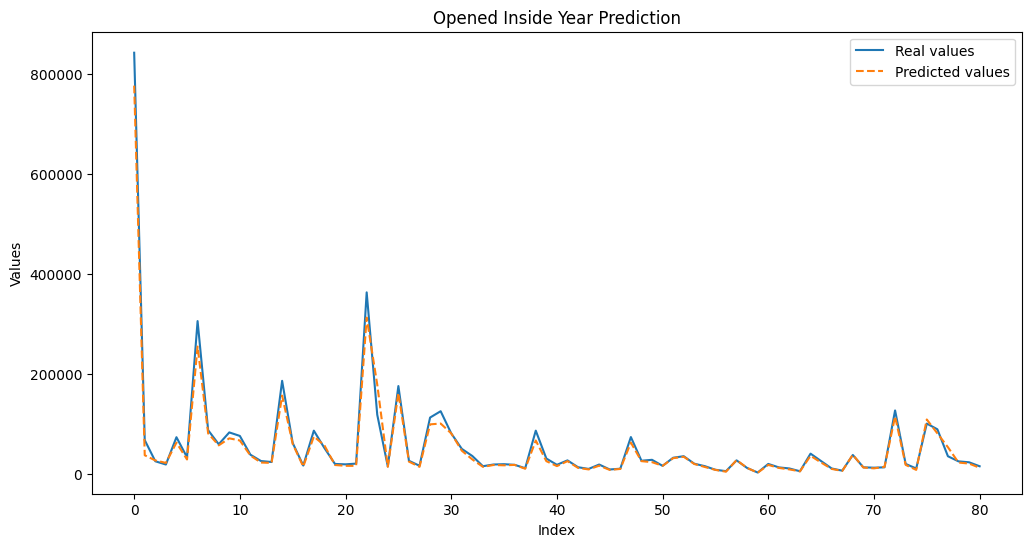

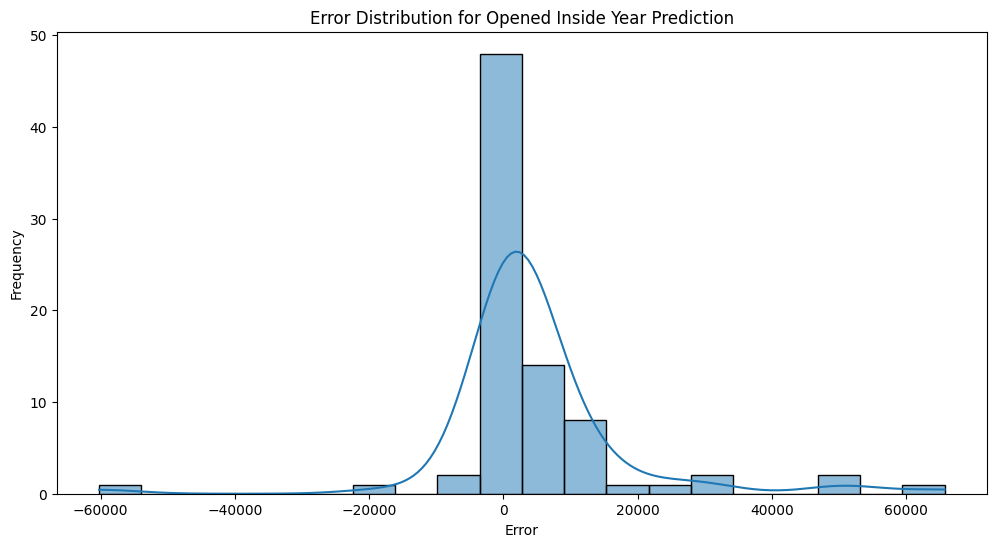

In [40]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_opened, y_pred_opened_with_dtr, 'Opened Inside Year Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_opened, y_pred_opened_with_dtr, 'Error Distribution for Opened Inside Year Prediction')

### DecisionTreeRegressor parametre tuning for predicting finished

In [ ]:
# Define the pipeline for finished prediction
model_for_finished = Pipeline(steps=[
    ('regressor', DecisionTreeRegressor())
])

# Define grid search parameters for finished prediction
param_grid_finished = {
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform grid search for finished prediction
grid_search_finished = GridSearchCV(model_for_finished, param_grid_finished, cv=5, verbose=2)
grid_search_finished.fit(X_train_finished, y_train_finished)
best_model_finished = grid_search_finished.best_estimator_

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished, y_test_finished)

In [ ]:
print(grid_search_finished.best_params_)

{'regressor__max_depth': 30, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 5}


In [21]:
# Define the pipeline for finished prediction
DecisionTreeRegressor_model_for_finished = DecisionTreeRegressor(max_depth=30,min_samples_leaf=4, min_samples_split=5)
DecisionTreeRegressor_model_for_finished.fit(X_train_finished, y_train_finished)

# Predict on test set for finished prediction
y_pred_finished_with_dtr = DecisionTreeRegressor_model_for_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished_with_dtr, y_test_finished)

Average Percentage Accuracy for prediction: 93.5413430217278


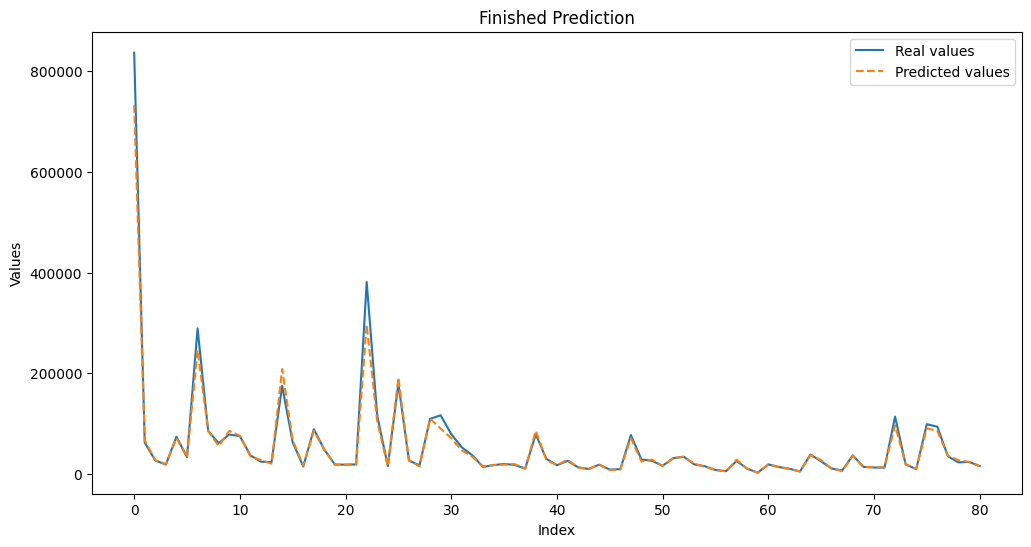

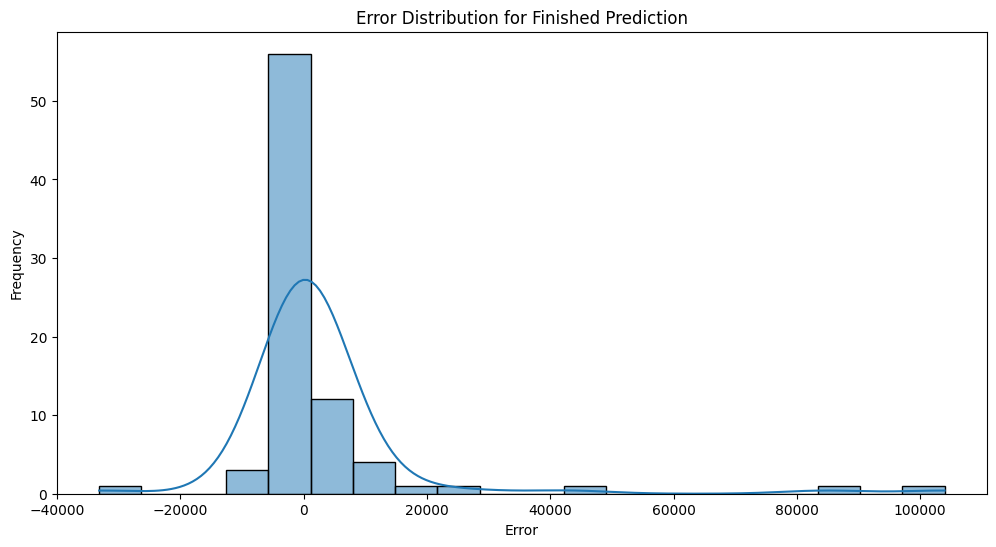

In [45]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished_with_dtr, 'Finished Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished_with_dtr, 'Error Distribution for Finished Prediction')

### Testing best models one after another


In [22]:
X_test_finished_with_predicted_opened_inside_year = X_test_finished.copy()
X_test_finished_with_predicted_opened_inside_year['opened_inside_year'] = y_pred_opened_with_dtr

# Predict on test set for finished prediction
y_pred_finished_with_dtr_with_predicted_oiy = DecisionTreeRegressor_model_for_finished.predict(X_test_finished_with_predicted_opened_inside_year)

calculate_accuracy(y_pred_finished_with_dtr_with_predicted_oiy, y_test_finished)

Average Percentage Accuracy for prediction: 86.70021604424498


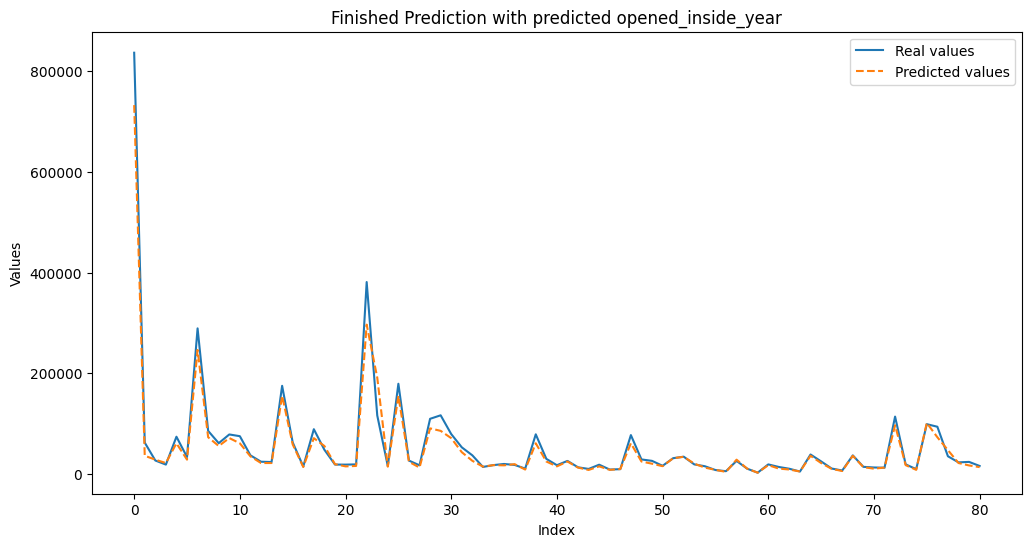

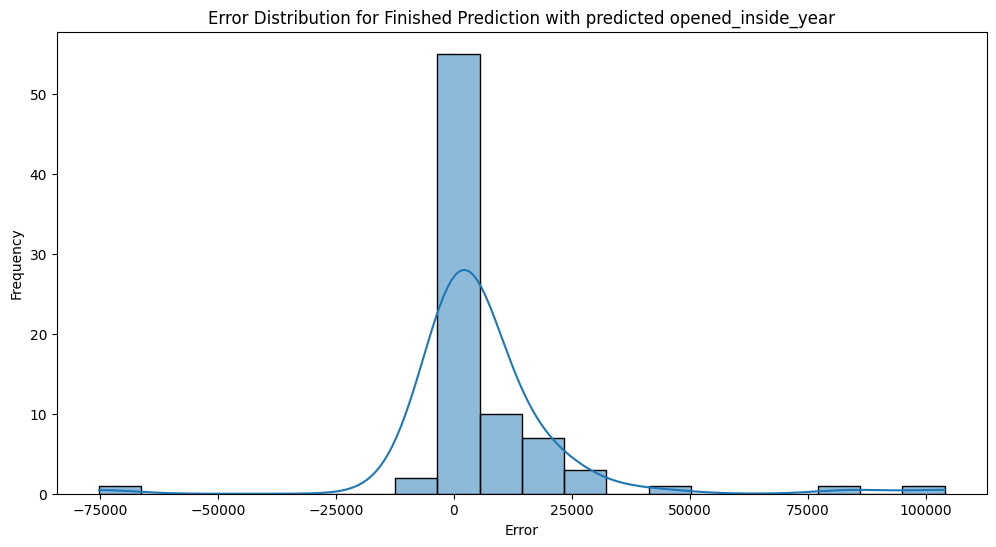

In [42]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished_with_dtr_with_predicted_oiy, 'Finished Prediction with predicted opened_inside_year')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished_with_dtr_with_predicted_oiy, 'Error Distribution for Finished Prediction with predicted opened_inside_year')


# RandomForestRegressor



#### RandomForestRegressor parametre tuning for predicting opened_inside_year

In [ ]:
# Define the pipeline for opened_inside_year prediction
model_for_opened_inside_year = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define grid search parameters
param_grid_opened = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Perform grid search for opened_inside_year prediction
grid_search_opened = GridSearchCV(model_for_opened_inside_year, param_grid_opened, cv=5, verbose=2)
grid_search_opened.fit(X_train_opened, y_train_opened)
best_model_opened_inside_year = grid_search_opened.best_estimator_

# Predict on test set for opened_inside_year prediction
y_pred_opened = best_model_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened, y_test_opened)

In [ ]:
print(grid_search_opened.best_params_)

{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}


In [23]:
# Define the pipeline for opened_inside_year prediction
RandomForestRegressor_model_for_opened_inside_year = RandomForestRegressor(max_depth=None,min_samples_leaf=2, n_estimators=5)
RandomForestRegressor_model_for_opened_inside_year.fit(X_train_opened, y_train_opened)

# Predict on test set for opened_inside_year prediction
y_pred_opened_with_rfr = RandomForestRegressor_model_for_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened_with_rfr, y_test_opened)

Average Percentage Accuracy for prediction: 90.1495841553276


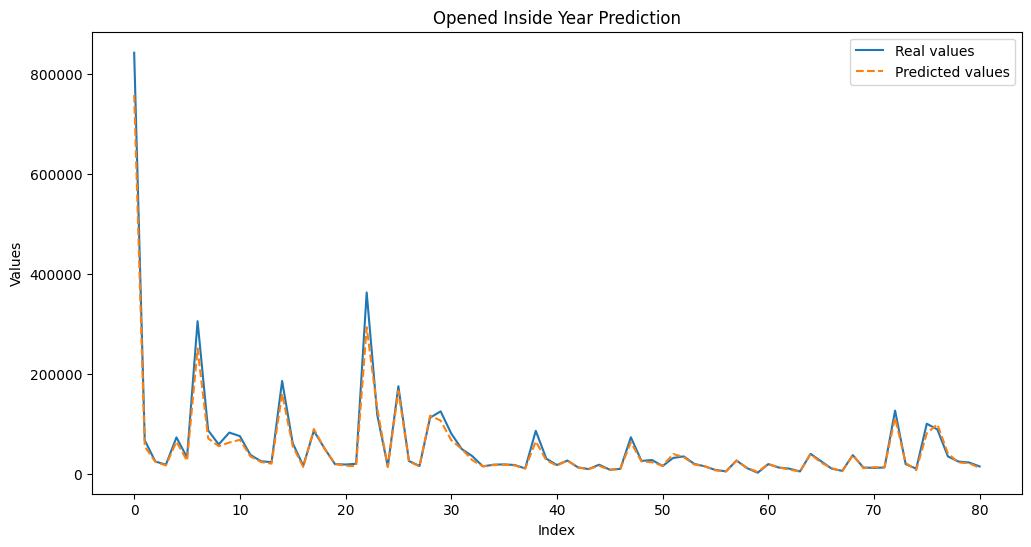

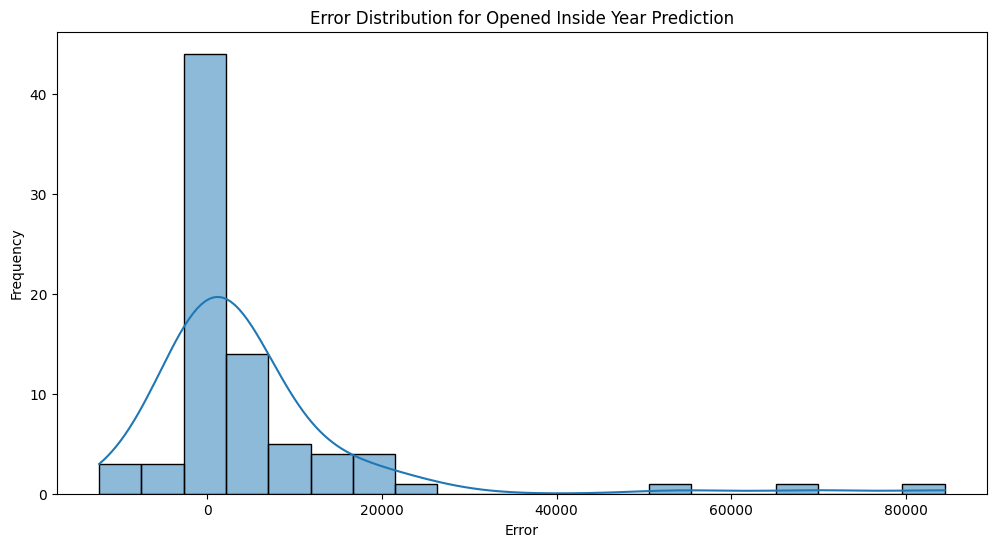

In [43]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_opened, y_pred_opened_with_rfr, 'Opened Inside Year Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_opened, y_pred_opened_with_rfr, 'Error Distribution for Opened Inside Year Prediction')

#### RandomForestRegressor parametre tuning for predicting finished

In [ ]:
# Define the pipeline for finished prediction
model_for_finished = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define grid search parameters
param_grid_finished = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}


# Perform grid search for finished prediction
grid_search_finished = GridSearchCV(model_for_finished, param_grid_finished, cv=5, verbose=2)
grid_search_finished.fit(X_train_finished, y_train_finished)
best_model_finished = grid_search_finished.best_estimator_

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished, y_test_finished)

In [ ]:
print(grid_search_finished.best_params_)

{'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}


In [24]:
# Define the pipeline for finished prediction
RandomForestRegressor_model_for_finished = RandomForestRegressor(max_depth=10,min_samples_leaf=2, n_estimators=300)
RandomForestRegressor_model_for_finished.fit(X_train_finished, y_train_finished)

# Predict on test set for finished prediction
y_pred_finished_with_rfr = RandomForestRegressor_model_for_finished.predict(X_test_finished)

calculate_accuracy(y_pred_opened_with_rfr, y_test_finished)

Average Percentage Accuracy for prediction: 90.04971759219214


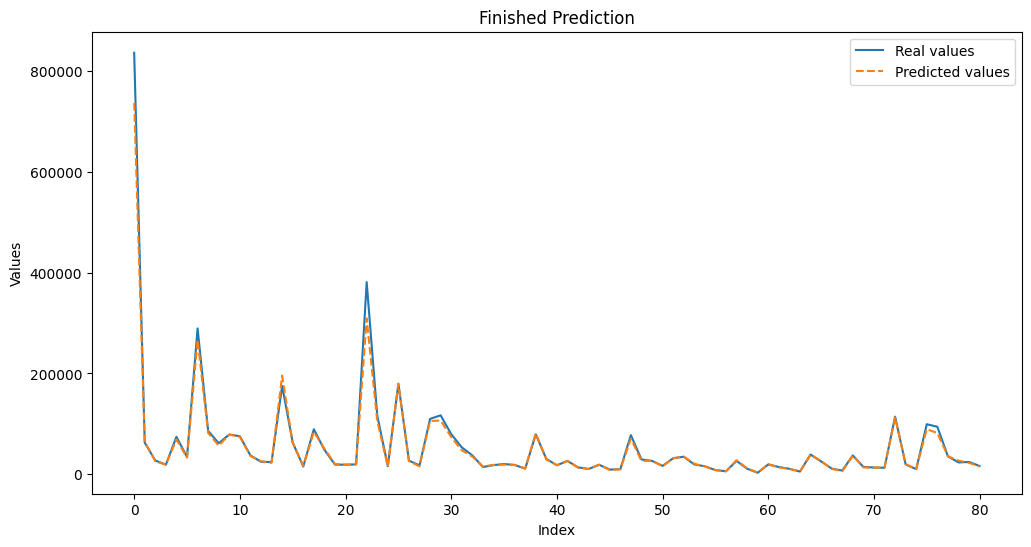

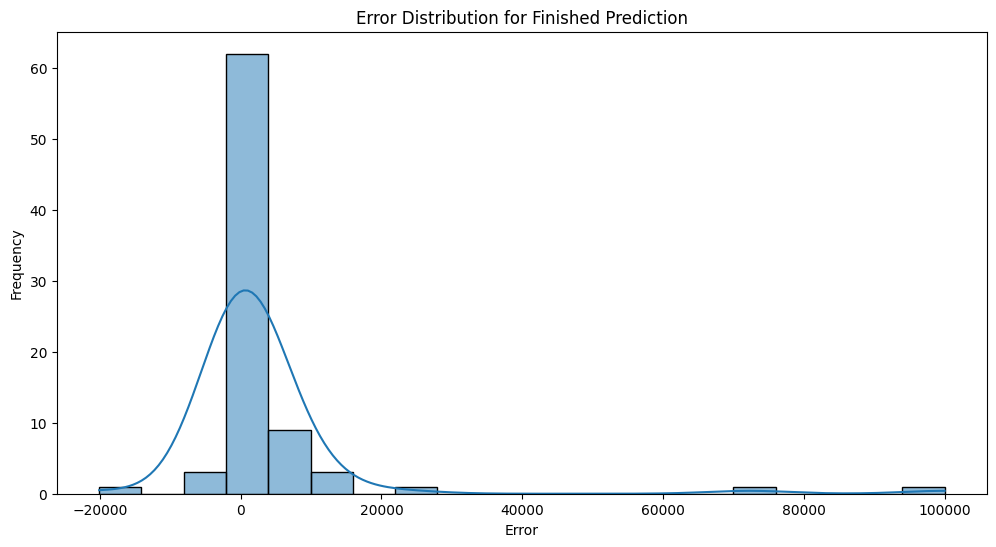

In [46]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished_with_rfr, 'Finished Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished_with_rfr, 'Error Distribution for Finished Prediction')

#### Testing best models one after another


In [29]:
X_test_finished_with_predicted_opened_inside_year = X_test_finished.copy()
X_test_finished_with_predicted_opened_inside_year['opened_inside_year'] = y_pred_opened_with_rfr

# Predict on test set for finished prediction
y_pred_finished_with_rfr_with_predicted_oiy = RandomForestRegressor_model_for_finished.predict(X_test_finished_with_predicted_opened_inside_year)

calculate_accuracy(y_pred_finished_with_rfr_with_predicted_oiy, y_test_finished)

Average Percentage Accuracy for prediction: 88.94703782801065


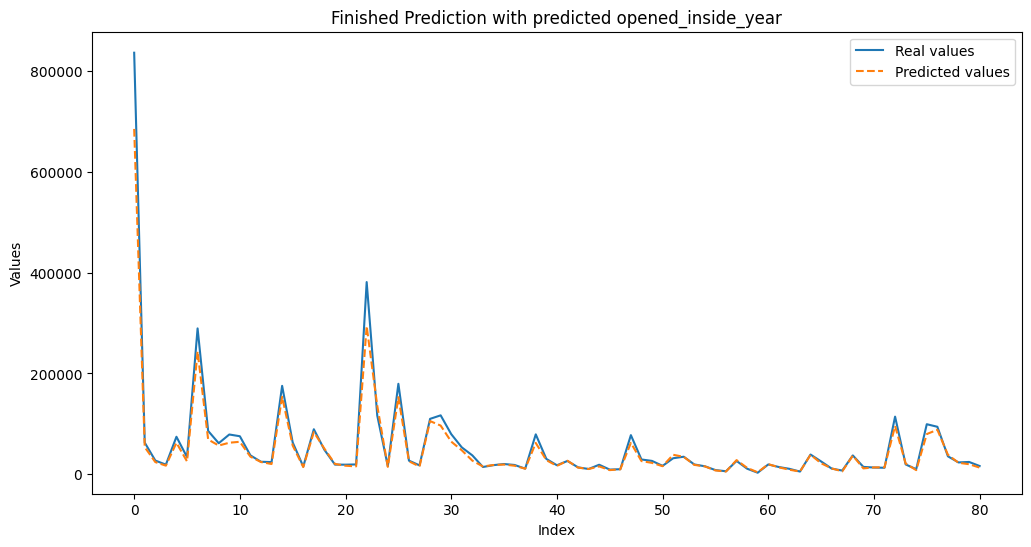

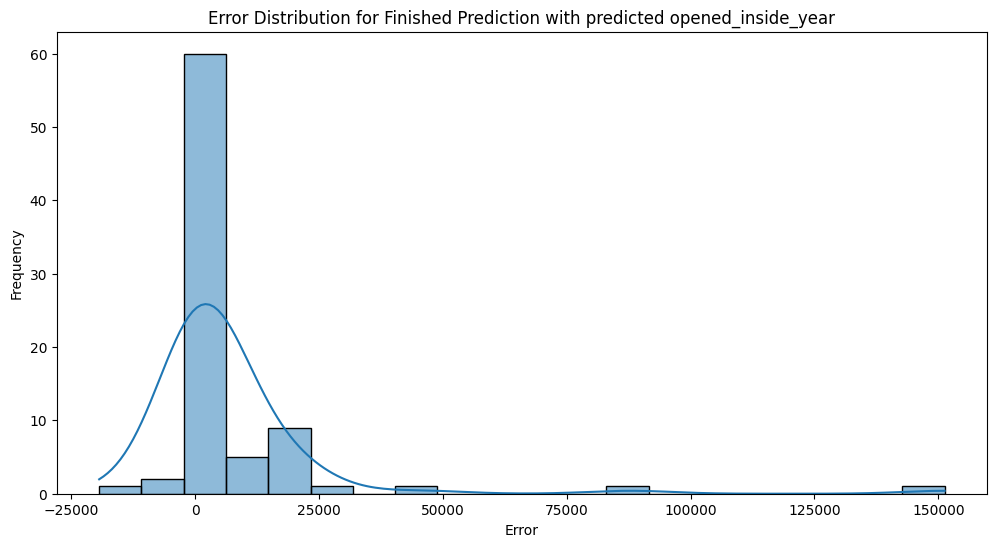

In [47]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished_with_rfr_with_predicted_oiy, 'Finished Prediction with predicted opened_inside_year')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished_with_rfr_with_predicted_oiy, 'Error Distribution for Finished Prediction with predicted opened_inside_year')


# GradientBoostingRegressor



#### GradientBoostingRegressor parametre tuning for predicting opened_inside_year

In [ ]:
# Define the pipeline for opened_inside_year prediction
model_for_opened_inside_year = Pipeline(steps=[
    ('regressor', GradientBoostingRegressor())
])

# Define grid search parameters
param_grid_opened = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}


# Perform grid search for opened_inside_year prediction
grid_search_opened = GridSearchCV(model_for_opened_inside_year, param_grid_opened, cv=5, verbose=2)
grid_search_opened.fit(X_train_opened, y_train_opened)
best_model_opened_inside_year = grid_search_opened.best_estimator_

# Predict on test set for opened_inside_year prediction
y_pred_opened = best_model_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened, y_test_opened)

In [ ]:
print(grid_search_opened.best_params_)

{'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 200}


In [26]:
# Define the pipeline for opened_inside_year prediction
GradientBoostingRegressor_model_for_opened_inside_year = GradientBoostingRegressor(learning_rate=0.1,max_depth=4, n_estimators=200)
GradientBoostingRegressor_model_for_opened_inside_year.fit(X_train_opened, y_train_opened)

# Predict on test set for opened_inside_year prediction
y_pred_opened_with_gbr = GradientBoostingRegressor_model_for_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened_with_gbr, y_test_opened)

Average Percentage Accuracy for prediction: 89.5337348181152


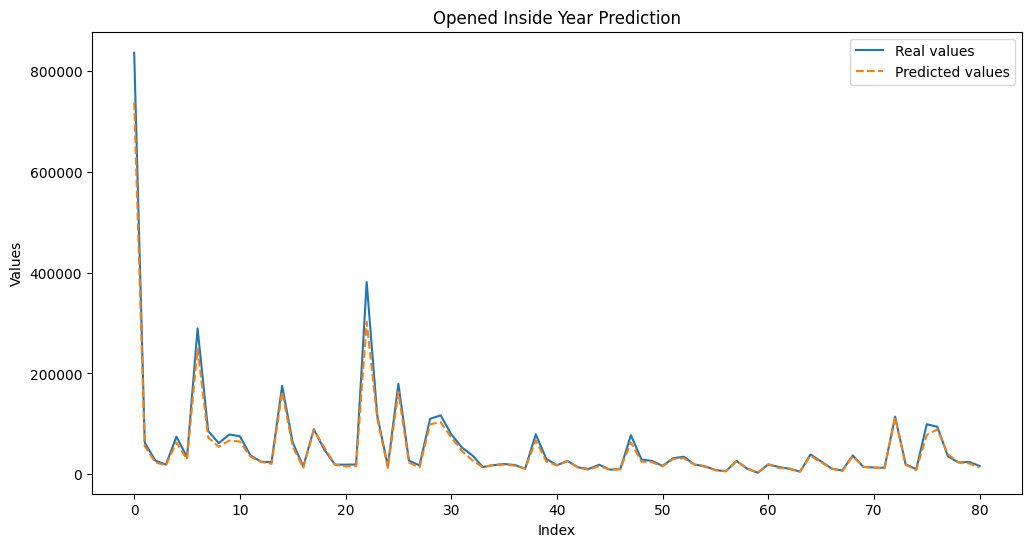

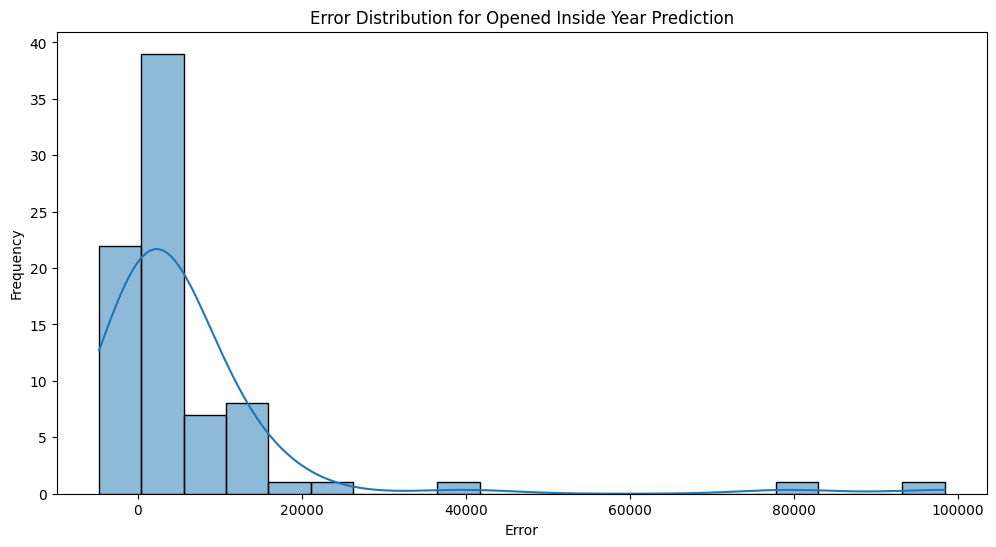

In [50]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_opened_with_gbr, 'Opened Inside Year Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_opened_with_gbr, 'Error Distribution for Opened Inside Year Prediction')


#### GradientBoostingRegressor parametre tuning for predicting finished

In [ ]:
# Define the pipeline for finished prediction
model_for_finished = Pipeline(steps=[
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Define grid search parameters
param_grid_finished = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}


# Perform grid search for finished prediction
grid_search_finished = GridSearchCV(model_for_finished, param_grid_finished, cv=5, verbose=2)
grid_search_finished.fit(X_train_finished, y_train_finished)
best_model_finished = grid_search_finished.best_estimator_

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished, y_test_finished)

In [ ]:
print(grid_search_finished.best_params_)

{'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}


In [28]:
# Define the pipeline for opened_inside_year prediction
GradientBoostingRegressor_model_for_finished = GradientBoostingRegressor(learning_rate=0.1,max_depth=3, n_estimators=300)
GradientBoostingRegressor_model_for_finished.fit(X_train_finished, y_train_finished)

# Predict on test set for opened_inside_year prediction
y_pred_finished_with_gbr = GradientBoostingRegressor_model_for_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished_with_gbr, y_test_finished)

Average Percentage Accuracy for prediction: 94.26176519897612


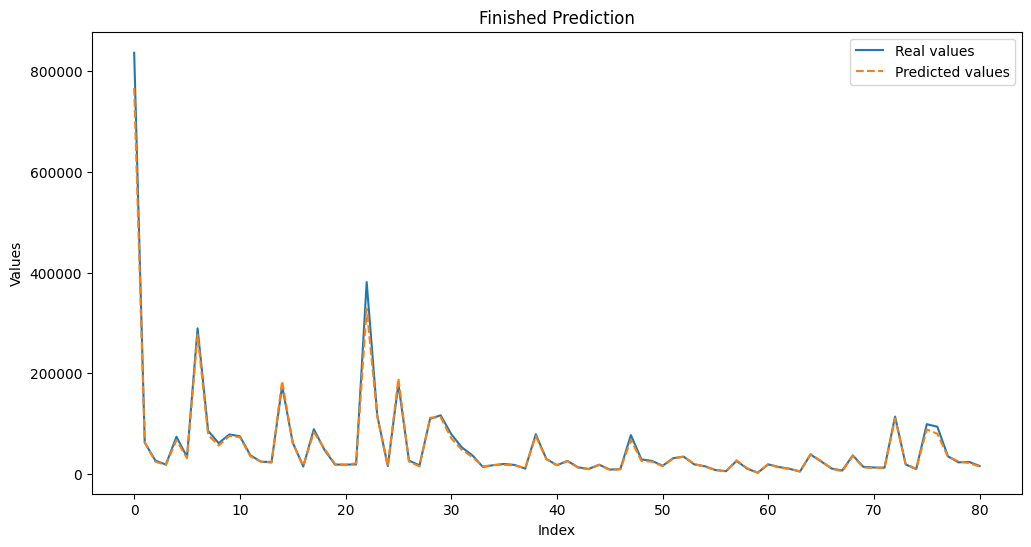

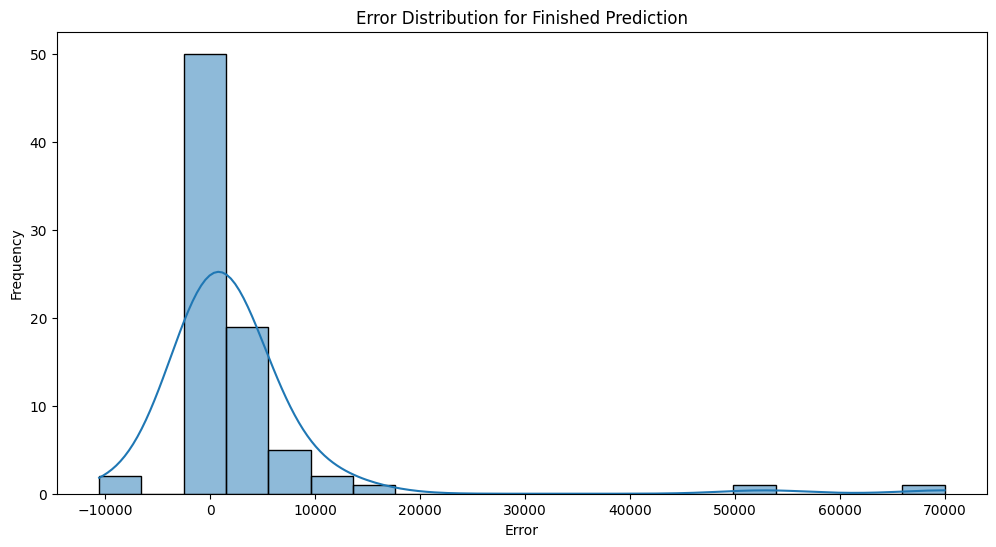

In [49]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished_with_gbr, 'Finished Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished_with_gbr, 'Error Distribution for Finished Prediction')


#### Testing best models one after another


In [31]:
X_test_finished_with_predicted_opened_inside_year = X_test_finished.copy()
X_test_finished_with_predicted_opened_inside_year['opened_inside_year'] = y_pred_opened_with_gbr

# Predict on test set for finished prediction
y_pred_finished_with_gbr_with_predicted_oiy = GradientBoostingRegressor_model_for_finished.predict(X_test_finished_with_predicted_opened_inside_year)

calculate_accuracy(y_pred_finished_with_gbr_with_predicted_oiy, y_test_finished)

Average Percentage Accuracy for prediction: 87.82689470878742


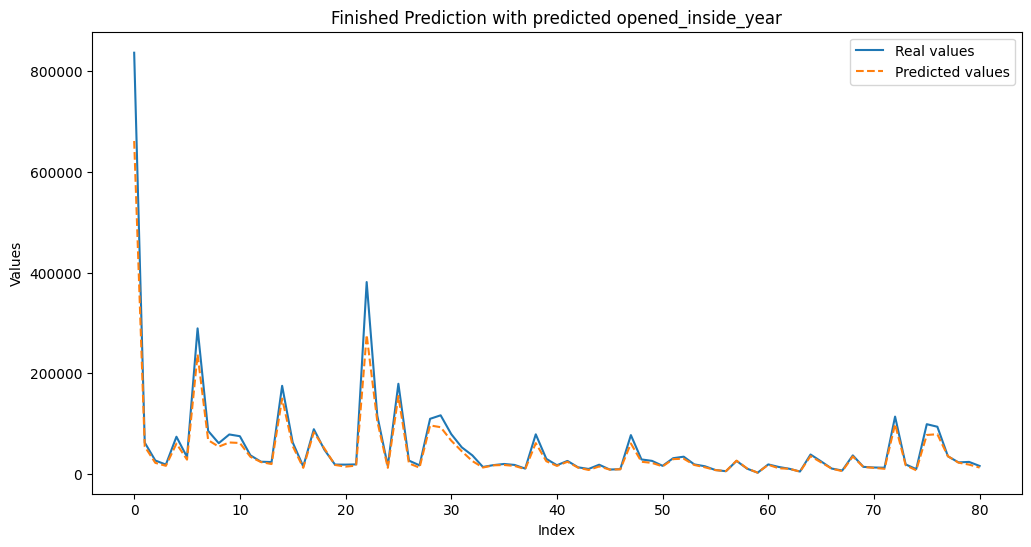

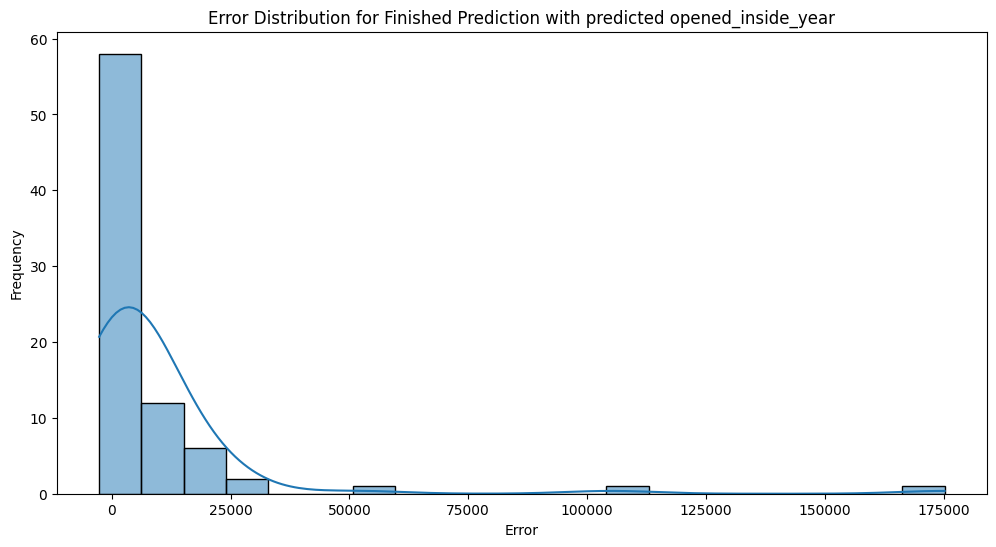

In [48]:
# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished_with_gbr_with_predicted_oiy, 'Finished Prediction with predicted opened_inside_year')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished_with_gbr_with_predicted_oiy, 'Error Distribution for Finished Prediction with predicted opened_inside_year')


# Farklı Modeller

In [32]:
predicted_oiy_values = {'DecisionTreeRegressor':y_pred_opened_with_dtr, 'RandomForestRegressor':y_pred_opened_with_rfr,'GradientBoostingRegressor' :y_pred_opened_with_gbr}
models = {'DecisionTreeRegressor':DecisionTreeRegressor_model_for_finished, 'RandomForestRegressor':RandomForestRegressor_model_for_finished,'GradientBoostingRegressor' :GradientBoostingRegressor_model_for_finished}


In [34]:
predicted_oiy_values = {'DecisionTreeRegressor': y_pred_opened_with_dtr, 'RandomForestRegressor': y_pred_opened_with_rfr, 'GradientBoostingRegressor': y_pred_opened_with_gbr}
models = {'DecisionTreeRegressor': DecisionTreeRegressor_model_for_finished, 'RandomForestRegressor': RandomForestRegressor_model_for_finished, 'GradientBoostingRegressor': GradientBoostingRegressor_model_for_finished}

for oiy_model, oiy_pred in predicted_oiy_values.items():
    for model_name, model in models.items():
        X_test_finished_with_predicted_opened_inside_year = X_test_finished.copy()
        X_test_finished_with_predicted_opened_inside_year['opened_inside_year'] = oiy_pred

        y_pred_finished = model.predict(X_test_finished_with_predicted_opened_inside_year)

        print(f"Opened inside year predicted with: {oiy_model}, Finished predicted with: {model_name}")
        calculate_accuracy(y_pred_finished, y_test_finished)



Opened inside year predicted with: DecisionTreeRegressor, Finished predicted with: DecisionTreeRegressor
Average Percentage Accuracy for prediction: 86.70021604424498
Opened inside year predicted with: DecisionTreeRegressor, Finished predicted with: RandomForestRegressor
Average Percentage Accuracy for prediction: 86.67392124855972
Opened inside year predicted with: DecisionTreeRegressor, Finished predicted with: GradientBoostingRegressor
Average Percentage Accuracy for prediction: 86.20724203635504
Opened inside year predicted with: RandomForestRegressor, Finished predicted with: DecisionTreeRegressor
Average Percentage Accuracy for prediction: 88.65663845787239
Opened inside year predicted with: RandomForestRegressor, Finished predicted with: RandomForestRegressor
Average Percentage Accuracy for prediction: 88.94703782801065
Opened inside year predicted with: RandomForestRegressor, Finished predicted with: GradientBoostingRegressor
Average Percentage Accuracy for prediction: 87.97218